In [1]:
import numpy as np
from scipy.integrate import odeint

import jax.numpy as jnp
from jax import grad, jit
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

### Interpolation

In [5]:
def lagrange_basis(x, x_i, i):
    """
    Compute the i-th Lagrange basis (l_i(x))
    """
    # for each x_i
    n = len(x_i)
    l_i = 1
    for j in range(n):
        if j != i:
            # compute the product
            l_i *= (x - x_i[j]) / (x_i[i] - x_i[j])
    return l_i

def lagrange_interpolation(x, x_i, y_i):
    """
    Compute the Lagrange interpolation polynomial at x
    
    Parameters:
    x: Point at which to evaluate the polynomial
    x_i: Array of x coordinates of the known data points
    y_i: Array of y coordinates of the known data points
    
    Returns:
    Interpolated value at x
    """
    n = len(x_i)
    p_x = 0
    for i in range(n):
        p_x += y_i[i] * lagrange_basis(x, x_i, i)
    return p_x

x_i = jnp.array([0.0, 1.0, 2.0, 3.0])
y_i = jnp.array([1.0, 2.0, 0.0, -1.0])
x = 1.5

interpolated_value = lagrange_interpolation(x, x_i, y_i)
print(f"Interpolated value at x={x}: {interpolated_value}")

Interpolated value at x=1.5: 1.125


### Alternative implementation operating on the whole array

In [6]:
def lagrange_polynomials(x, t):
    """ Generate Lagrange basis polynomials for given nodes x at a point t """
    n = len(x)
    L = jnp.ones(n)
    for i in range(n):
        for j in range(n):
            if i != j:
                L = L.at[i].set(L[i] * (t - x[j]) / (x[i] - x[j]))
    return L

def interpolate_y_values(y_values, x_nodes, t):
    """ Interpolate y values using Lagrange polynomials at point t """
    L = lagrange_polynomials(x_nodes, t)
    return jnp.dot(L, y_values)


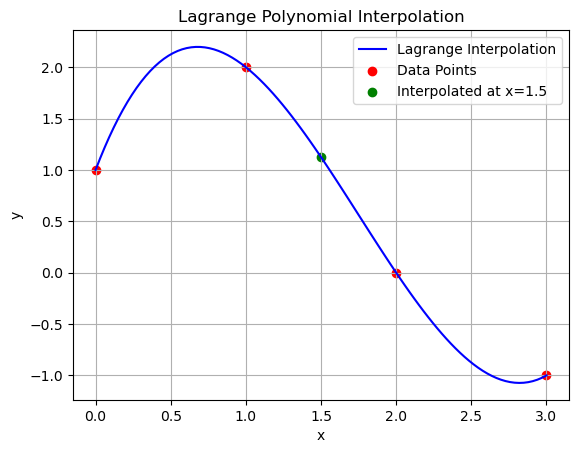

In [7]:
fig, ax = plt.subplots()
x_vals = jnp.linspace(0, 3, 100)
# y_vals = jnp.array([lagrange_interpolation(xi, x_i, y_i) for xi in x_vals])

y_vals = jnp.array([interpolate_y_values(y_i, x_i, xi) for xi in x_vals])

ax.plot(x_vals, y_vals, label='Lagrange Interpolation', color='blue')

ax.scatter(x_i, y_i, color='red', label='Data Points')
ax.scatter(x, interpolated_value, color='green', label=f'Interpolated at x={x}')

ax.grid(True)
ax.set_title('Lagrange Polynomial Interpolation')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.show()

## Example:
* y(0) = 10 <br>
* y′(t) = −2 * t
#### Analytical
* y(t) = - t^2 + c
* => c = 10 


### Sample Solution

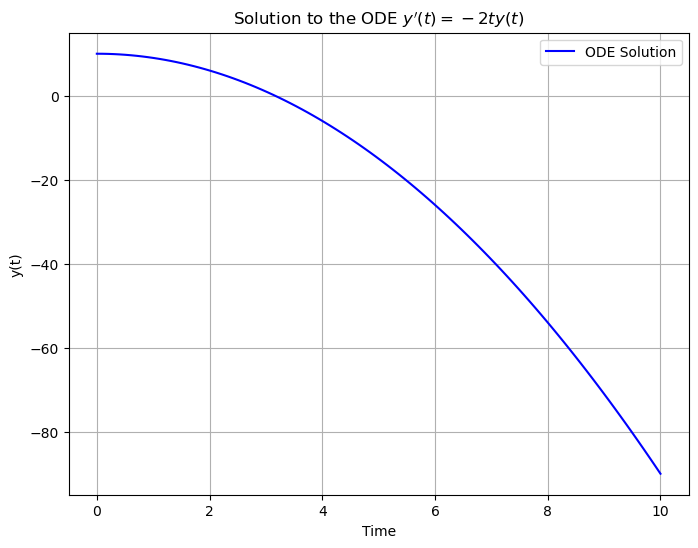

In [8]:
def model(y, t):
    dydt = -2 * t
    return dydt

y0 = 10

t = np.linspace(0, 10, 100)

y = odeint(model, y0, t)

plt.figure(figsize=(8, 6))
plt.plot(t, y, label='ODE Solution', color='blue')
plt.title('Solution to the ODE $y\'(t) = -2ty(t)$')
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from scipy.optimize import root

In [10]:
def chebyshev_nodes(n, a, b):
    i = np.arange(1, n + 1)
    return (a + b) / 2 + (b - a) / 2 * np.cos((2 * i - 1) * np.pi / (2 * n))


In [11]:
def collocation_system(y_values, x_nodes, x0, y0):
    """ Define the system of equations from the collocation method """
    n = len(x_nodes)
    
    # Generate a polynomial from y_values using Lagrange basis
    interpolate = jit(lambda t: interpolate_y_values(y_values, x_nodes, t))
    d_interpolate = grad(interpolate)
    
    # Equations from collocation points
    equations = [d_interpolate(x_nodes[i]) - model(x_nodes[i], y_values[i]) for i in range(n)]
    # Ensure the initial condition at the first node if it's zero
    equations[n] = y_values[0] - y0  # Adjust the equation for the initial condition directly
    
    print(equations)
    return np.array(equations)

n_nodes = 5
a, b = 0, 10 

x_nodes = chebyshev_nodes(n_nodes, b, a) # in reverse order
print("Chebyshev nodes:", x_nodes)
initial_guess = np.array([0.1] * (n_nodes)) 
print("Initial guess:", initial_guess)

Chebyshev nodes: [0.24471742 2.06107374 5.         7.93892626 9.75528258]
Initial guess: [0.1 0.1 0.1 0.1 0.1]


In [12]:
# solve
y_solution = fsolve(lambda y: collocation_system(y, x_nodes, 10.0), initial_guess)

# result = root(lambda y: collocation_system(y, x_nodes, 10.0), initial_guess, method='lm')
# y_solution = result.x

# print("Solution at nodes:", y_solution)

TypeError: collocation_system() missing 1 required positional argument: 'y0'

In [13]:
# Plotting the solution
t_values = np.linspace(0, 10, 100)
y_interp = [interpolate_y_values(y_solution, x_nodes, t) for t in t_values]

plt.figure(figsize=(8, 6))
plt.scatter(x_nodes, y_solution, color='red', label='Collocation Points')
plt.plot(t_values, y_interp, label='Interpolated Solution', color='blue')
plt.title('Solution of IVP using Lagrange Polynomial Collocation')
plt.xlabel('t')
plt.ylabel('y(t)')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'y_solution' is not defined

## Barycentric Polynomial

The barycentric form of the Lagrange interpolation polynomial is given by:

$
p(x) = \frac{\sum_{j=0}^{n} \frac{w_j y_j}{x - x_j}}{\sum_{j=0}^{n} \frac{w_j}{x - x_j}} 
$

where:
- \( x_j \) are the interpolation nodes,
- \( y_j \) are the values at these nodes,
- \( w_j \) are the barycentric weights.

## Barycentric Weights

The weights \( w_j \) are computed as:

$
w_j = \frac{1}{\prod_{\substack{k=0 \\ k \neq j}}^{n} (x_j - x_k)}, \quad j = 0, 1, \ldots, n 
$


"*The end result is a fourth-order derivative matrix defined on the collocation points.*"
### Derivative matrix
To construct a derivative matrix defined on collocation points:

1. **Choose Collocation Points**: Select specific points (like the zeros of Chebyshev polynomials) where the function and its derivatives will be evaluated.

2. **Polynomial Approximation**: Approximate the function by a polynomial (such as a Chebyshev polynomial) that goes through these collocation points.

3. **Differentiation**: Compute the derivatives of this polynomial at each collocation point. This involves differentiating the polynomial expression analytically.

4. **Matrix Representation**: Construct a matrix where each row corresponds to the derivative of the polynomial at a specific collocation point with respect to each coefficient of the polynomial. This matrix effectively represents the derivative operation in matrix form, translating continuous derivative operations into discrete approximations useful for numerical computations.

This matrix allows for the transformation of function values at collocation points into values of their derivatives, crucial for solving differential equations numerically.

# Collocation from the basics

Let's solve a differential equation: <br>
$y' + 3y = 2e^{-t} \sin(t) + e^{-t} \cos(t)$ <br>


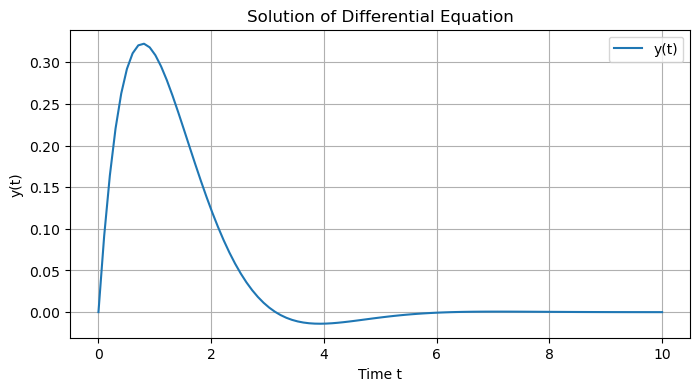

In [2]:
import jax.numpy as jnp
from jax.experimental.ode import odeint
import numpy as np
import matplotlib.pyplot as plt

# differential equation function
def dydt(y, t):
    # define the RHS of the equation
    rhs = 2 * jnp.exp(-t) * jnp.sin(t) + jnp.exp(-t) * jnp.cos(t)
    # dy/dt = RHS - 3y = f(y)
    return rhs -3 * y

# initial condition
y0 = jnp.array([0.0])

# time points for the solution
t = np.linspace(0, 10, 100)

# solve the ODE
y_sol = odeint(dydt, y0, t)

plt.figure(figsize=(8, 4))
plt.plot(t, y_sol, label='y(t)')
plt.title('Solution of Differential Equation')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.legend()
plt.grid(True)
plt.show()


Check if $y(t) = e^{-t}sin(t)$ is a solution

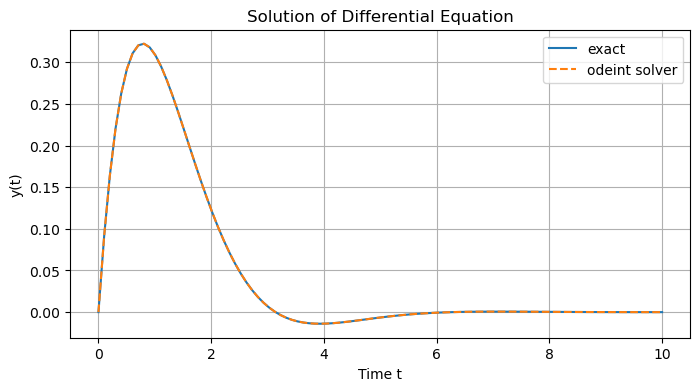

In [3]:
def solution(t):
    return jnp.exp(-t) * jnp.sin(t)

np.linspace(0, 10, 100)

y_exact = solution(t)

plt.figure(figsize=(8, 4))
plt.plot(t, y_exact, label='exact')
plt.plot(t, y_sol,  '--', label='odeint solver')
plt.title('Solution of Differential Equation')
plt.xlabel('Time t')
plt.ylabel('y(t)')
plt.legend()
plt.grid(True)
plt.show()

## Collocation approach


#### 1) Verify that we can effictively interpolate through the given function

0.1229556


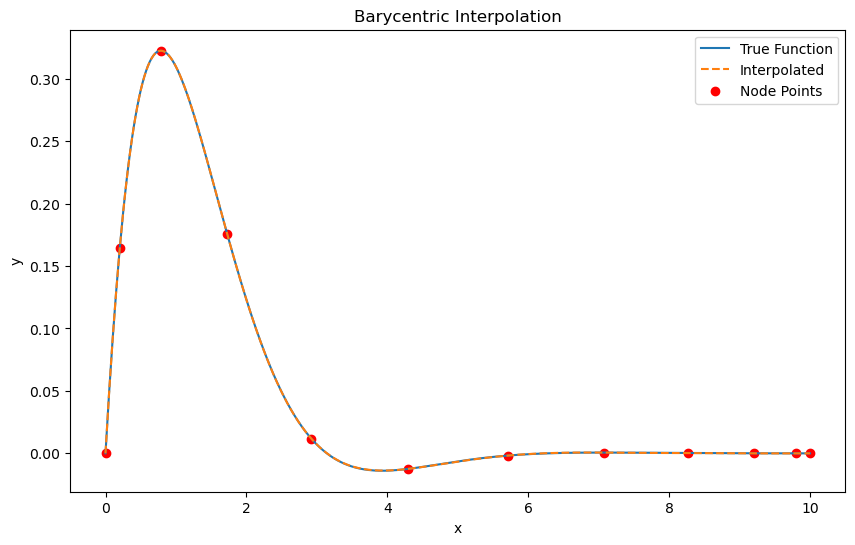

In [4]:
from interpolation import *

# generate 24 Chebyshev2 nodes
poly = BarycentricInterpolation(n=12, kind='chebyshev2', start=0, stop=10)

y_at_nodes = solution(poly.nodes)

#eg. for 1 point
print(poly.interpolate(y_at_nodes, 2))

x_plot = np.linspace(0, 10, 400)
# interpolate based on 24 nodese
interpolated_y = np.array([poly.interpolate(y_at_nodes, xi) for xi in x_plot]) 

plt.figure(figsize=(10, 6))
plt.plot(x_plot, solution(x_plot), label='True Function')
plt.plot(x_plot, interpolated_y, '--', label='Interpolated')
plt.scatter(poly.nodes, y_at_nodes, color='red', label='Node Points')
plt.title('Barycentric Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

#### 2) Solve through collocation

Have to form a system of equations to solve: <br>
$y' + 3y = 2e^{-t} \sin(t) + e^{-t} \cos(t)$ <br>

The initial condition is $y(0) = 0$ <br>
$\therefore$ $2e^{-t} \sin(t) + e^{-t} \cos(t) - y'= 0$

Assume we will be solving based on 24 collocation points;
Obtain y(t) for the 24 collocation points <br>

Let's rewrite $y(t) = 2e^{-t} \sin(t) + e^{-t} \cos(t) - y'$ as Lagrange polynomial (the chosen approximating function): <br>
$p(x) = y_0 \ell_0(x) + y_1 \ell_1(x) + \cdots + y_n \ell_n(x) = \sum_{k=0}^n y_k \ell_k(x)$<br>

For 24 points, we would have $\sum_{k=0}^{24} y_k \ell_k(x)$<br>



--- 
#### Implementation
`AIM`: express as *Ay = b* system
* *b* evaluating RHS at each node
* *A* is the LHS without $y_k$
* $y$ formed by all $y_k$

`1.` For each collocation point $t_i$, we substitute $y(t_i)$ and $y'(t_i)$ into the differential equation, resulting in:

$ \sum_{k=0}^{n-1} y_k \ell_k'(t_i) + 3 \sum_{k=0}^{n-1} y_k \ell_k(t_i) = 2e^{-t_i} \sin(t_i) + e^{-t_i} \cos(t_i) $

Each row represents one collocation point, and each column next coefficient $l_k$ or $l_k'$ <br>
Each element $A_{ij}$ of the matrix $A$ is formed as: <br>
* $ A_{ij} = \ell'_j(t_i) + 3\ell_j(t_i) $
for $i, j = 0, 1, \dots, n-1$ <br>

* $b_i = 2e^{-t_i} \sin(t_i) + e^{-t_i} \cos(t_i)$

`2.` Generate barycentric nodes, these are the $t_i$

In [5]:
poly = BarycentricInterpolation(n=24, kind='chebyshev2', start=0, stop=10)
poly.nodes

array([ 0.        ,  0.04657027,  0.18541356,  0.41394349,  0.72790298,
        1.12144355,  1.58723428,  2.11659839,  2.69967481,  3.32560194,
        3.98271993,  4.65878793,  5.34121207,  6.01728007,  6.67439806,
        7.30032519,  7.88340161,  8.41276572,  8.87855645,  9.27209702,
        9.58605651,  9.81458644,  9.95342973, 10.        ])

`3.` Define formulas to compute lagrange basis and lagrange basis derivative

`3.1` Lagrange Basis: <br>
$\ell_i(x) = \prod_{\substack{j=0 \\ j \ne i}}^{n-1} \frac{x - x_j}{x_i - x_j} \quad (0 \le i < n)$

In [6]:
def lagrange_basis(x, i, xi):
    """ Compute the product form of the Lagrange basis polynomial at x for index i
    Parameters:
    x (array_like): Array of points at which the derivative of the Lagrange basis polynomial is to be evaluated.
    i (int) Index of the Lagrange basis polynomial for which the derivative is being computed.
    xi (array_like): Array of nodes used to construct the Lagrange basis polynomials. 

    Returns (array_like):  The derivative of the i-th Lagrange basis polynomial evaluated at each point in x.
    """
    terms = [(x - xi[j]) / (xi[i] - xi[j]) for j in range(len(xi)) if i != j]
    return jnp.prod(jnp.stack(terms), axis=0)

`3.2` First Derivative:<br>
$$\ell_j'(x_i) = \frac{w_j / w_i}{x_i - x_j}$$
where: <br>
$$w_j = \frac{1}{\ell'(x_j)} = \frac{1}{\prod_{k=1, k \ne j}^n (x_j - x_k)}, \quad j = 1, \ldots, n.$$

`implementation for the method above is in the next notebook`

---

$\ell_j'(x_i) = \sum_{\substack{k=0 \\ k \neq j}}^n \left( \prod_{\substack{m=0 \\ m \neq j, m \neq k}}^n \frac{x_i - x_m}{x_j - x_m} \right) \frac{1}{x_i - x_k}$


$\therefore$ we can express the array of derivatives for all of the nodes as:<br>
$\ell_i'(x) = \sum_{\substack{k=0 \\ k \neq i}}^n \left( \prod_{\substack{j=0 \\ j \neq i, j \neq k}}^n \frac{x - x_j}{x_i - x_j} \right) \frac{1}{x - x_k}$


In [74]:
def lagrange_basis_derivative(x, i, xi):
    """ compute the derivative for all x
    Parameters:
    x (array_like): Array of points at which the derivative of the Lagrange basis polynomial is to be evaluated.
    i (int) Index of the Lagrange basis polynomial for which the derivative is being computed.
    xi (array_like): Array of nodes used to construct the Lagrange basis polynomials. 

    Returns (array_like):  The derivative of the i-th Lagrange basis polynomial evaluated at each point in x.
    """
    n = len(xi)
    # initialize the resulting sum array with zeros, same shape as x
    sum_result = jnp.zeros_like(x) 
    for k in range(n):
        # exclude the node corresponding to the basis polynomial we're differentiating
        if k != i:
            # calculate the product for the derivative excluding xi[i] and xi[k]
            product_terms = [(x - xi[m]) / (xi[i] - xi[m]) for m in range(n) if m != i and m != k]
            # add the term to the sum, dividing by (xi[i] - xi[k]) as per the derivative formula
            sum_result += jnp.prod(jnp.stack(product_terms), axis=0) / (xi[i] - xi[k])
    return sum_result

`3.3` Check the functions work as expected

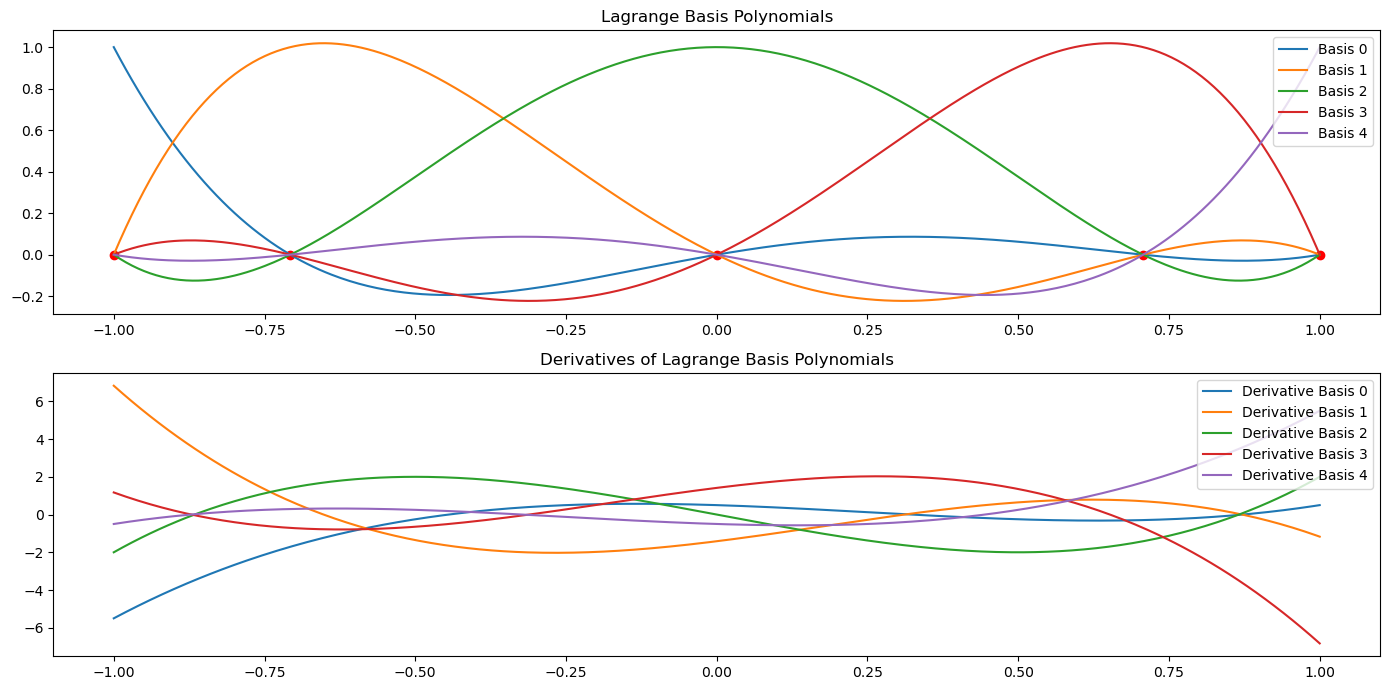

In [10]:
n = 5
a, b = -1, 1  # interval

# compute Chebyshev nodes
xi = BarycentricInterpolation(n=n, kind='chebyshev2', start=a, stop=b).nodes

# generate x values for plotting
x_plot = np.linspace(a, b, 400) # points where derivatives will be evaluated
basis = np.zeros((n, len(x_plot)))
derivatives = np.zeros((n, len(x_plot)))

# calculate basis and derivatives for plotting for each node
for i in range(n): 
    # xi - nodes, i - index of the basis polynomial
    basis[i, :] = lagrange_basis(x_plot, i, xi)
    derivatives[i, :] = lagrange_basis_derivative(x_plot, i, xi)

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
for i in range(n):
    plt.plot(x_plot, basis[i, :], label=f'Basis {i}')
plt.scatter(xi, np.zeros(n), color='red')  # nodes
plt.title('Lagrange Basis Polynomials')
plt.legend(loc='upper right')

plt.subplot(2, 1, 2)
for i in range(n):
    plt.plot(x_plot, derivatives[i, :], label=f'Derivative Basis {i}')
plt.title('Derivatives of Lagrange Basis Polynomials')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

`4.` Express in the `Ay = b` form

Parameters of lagrange_basis_derivative() and lagrange_basis():<br>
`x` (array_like): Array of points at which the derivative of the Lagrange basis polynomial is to be evaluated.<br>
`i` (int) Index of the Lagrange basis polynomial for which the derivative is being computed.<br>
`xi` (array_like): Array of nodes used to construct the Lagrange basis polynomials. <br>

In [59]:
import jax.numpy as jnp

def construct_matrix_and_vector(xi, y0):
    """
    Construct the matrix A and vector b for solving an ODE using Lagrange basis polynomials,
    incorporating an initial value condition.

    Parameters:
    xi (array_like): Nodes at which the values of the ODE solution are known or to be calculated.
    y0 (float): The initial value at the first node xi[0].

    Returns:
    tuple: A tuple containing the matrix A and vector b for the ODE problem.
    """
    n = len(xi)
    A = jnp.zeros((n, n))
    b = jnp.zeros(n)

    # Set the initial condition
    A = A.at[0, :].set(0)  
    A = A.at[0, 0].set(1) 
    b = b.at[0].set(y0) 
    # 1y0 + 0y1 + 0y2 + ... = y0

    for i in range(1, n): 
        for j in range(n):
            lj_prime = lagrange_basis_derivative(xi[i], j, xi)  
            lj = lagrange_basis(xi[i], j, xi)               

            # Construct the matrix A
            A = A.at[i, j].set(lj_prime + 3 * lj)

        # RHS of the differential equation evaluated at nodes
        b = b.at[i].set(2 * jnp.exp(-xi[i]) * jnp.sin(xi[i]) + jnp.exp(-xi[i]) * jnp.cos(xi[i]))
    
    return A, b

In [60]:
n = 12
a, b = 0, 10
poly = BarycentricInterpolation(n=n, kind='chebyshev2', start=a, stop=b)
xi = poly.nodes

In [61]:
A, b = construct_matrix_and_vector(xi, 0)

`5.` Solve

`n = 12`

In [30]:
from jax.scipy.linalg import solve

def find_solution(A, b):
    """
    Solve the linear system of equations A * y = b for y.
    """
    # Solve the linear system
    y = solve(A, b)
    return y

In [31]:
y_coeff = find_solution(A, b)
print("Solution coefficients y:", y_coeff)

Solution coefficients y: [ 2.4144072e-08  1.6444622e-01  3.2226744e-01  1.7603807e-01
  1.1548218e-02 -1.2402396e-02 -1.8857159e-03  6.8409694e-04
  1.6665022e-04  6.8682595e-05 -4.1789444e-05 -2.9762208e-05]


`6.` Plot

/Users/mariiashapo/Desktop/project_2324/NODE/collocation/interpolation.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  w[i] /= (self.nodes[i] - self.nodes[j])


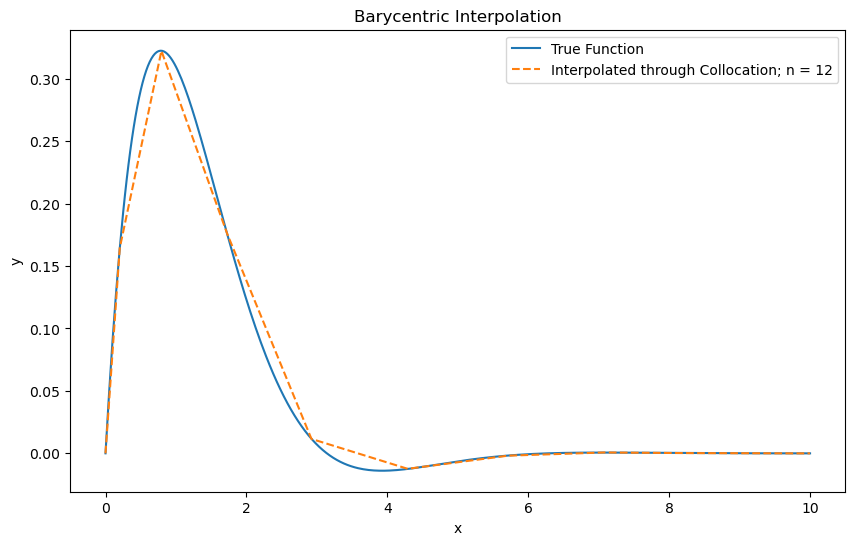

In [32]:
poly = BarycentricInterpolation(n=n, kind='chebyshev2', start=a, stop=b)

x_plot = np.linspace(0, 10, 400)
# interpolate based on 24 nodese
interpolated_y = np.array([poly.interpolate(y_coeff, xi) for xi in x_plot]) 

plt.figure(figsize=(10, 6))
plt.plot(x_plot, solution(x_plot), label='True Function')
plt.plot(xi, y_coeff, '--', label='Interpolated through Collocation; n = 12')
plt.title('Barycentric Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

`n = 24`

In [62]:
n = 36
a, b = 0, 10
poly = BarycentricInterpolation(n=n, kind='chebyshev2', start=a, stop=b)
xi = poly.nodes

In [63]:
A, b = construct_matrix_and_vector(xi, 0)

In [64]:
y_coeff = find_solution(A, b)
print("Solution coefficients y:", y_coeff)

Solution coefficients y: [ 2.2795328e-07  1.9726321e-02  7.4068598e-02  1.4966302e-01
  2.2788015e-01  2.8960398e-01  3.2035094e-01  3.1413531e-01
  2.7465510e-01  2.1330610e-01  1.4486487e-01  8.2674421e-02
  3.5222765e-02  5.1213298e-03 -9.7366665e-03 -1.3909582e-02
 -1.2225068e-02 -8.4155183e-03 -4.6937731e-03 -1.9785664e-03
 -3.7597102e-04  3.7210181e-04  5.9515290e-04  5.5769907e-04
  4.2669490e-04  2.8799556e-04  1.7544797e-04  9.5608782e-05
  4.3730397e-05  1.2174376e-05 -5.9580470e-06 -1.5835969e-05
 -2.0918718e-05 -2.3363600e-05 -2.4412015e-05 -2.4697147e-05]


/Users/mariiashapo/Desktop/project_2324/NODE/collocation/interpolation.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  w[i] /= (self.nodes[i] - self.nodes[j])


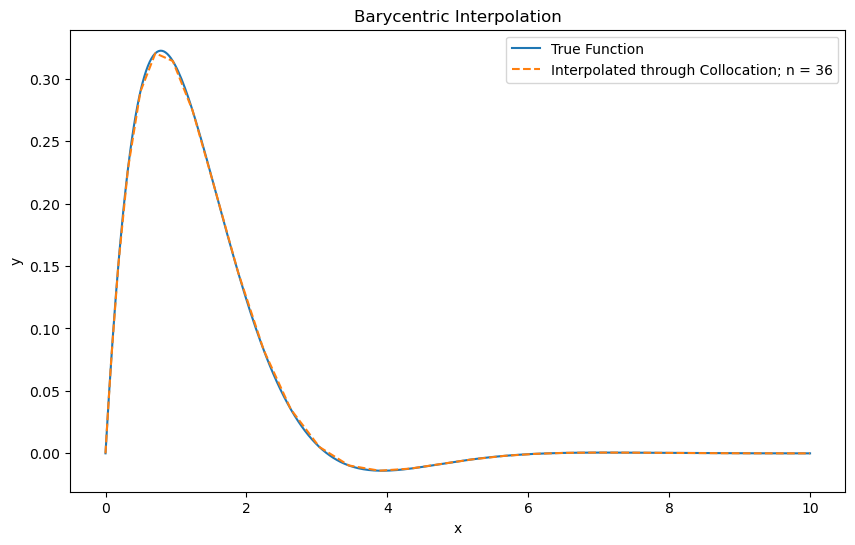

In [65]:
poly = BarycentricInterpolation(n=n, kind='chebyshev2', start=a, stop=b)

x_plot = np.linspace(0, 10, 400)
# interpolate based on 24 nodese
interpolated_y = np.array([poly.interpolate(y_coeff, xi) for xi in x_plot]) 

plt.figure(figsize=(10, 6))
plt.plot(x_plot, solution(x_plot), label='True Function')
plt.plot(xi, y_coeff, '--', label=f'Interpolated through Collocation; n = {n}')
plt.title('Barycentric Interpolation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [53]:
import jax.numpy as jnp
from jax import vmap

def vectorized_lagrange_basis(xi, xi_grid):
    """Vectorized computation of Lagrange basis across a grid of points xi evaluated at each xi."""
    # Assuming that lagrange_basis can take vectorized inputs
    # Placeholder function needs actual implementation
    return jnp.array([[lagrange_basis(x, j, xi) for j in range(len(xi))] for x in xi_grid])

def vectorized_lagrange_derivative(xi, xi_grid):
    """Vectorized computation of derivatives of Lagrange basis across xi grid evaluated at each xi."""
    # Assuming that lagrange_basis_derivative can take vectorized inputs
    # Placeholder function needs actual implementation
    return jnp.array([[lagrange_auth_derivative(x, j, xi) for j in range(len(xi))] for x in xi_grid])

def construct_matrix_and_vector(xi, y0):
    """
    Construct the matrix A and vector b for solving an ODE using Lagrange basis polynomials,
    incorporating an initial value condition.
    """
    n = len(xi)
    A = jnp.zeros((n, n))
    b = jnp.zeros(n)

    # Set the initial condition at the first node
    A = A.at[0, 0].set(1)
    b = b.at[0].set(y0)

    # Precompute the Lagrange basis and derivatives for all nodes
    all_lj = vectorized_lagrange_basis(xi, xi)
    all_lj_prime = vectorized_lagrange_derivative(xi, xi)

    # Fill the matrix A for i from 1 to n using precomputed values
    for i in range(1, n):
        for j in range(n):
            # Retrieve precomputed values
            lj_prime = all_lj_prime[i, j]
            lj = all_lj[i, j]

            # Construct the matrix A
            A = A.at[i, j].set(lj_prime + 3 * lj)

        # RHS of the differential equation evaluated at nodes
        b = b.at[i].set(2 * jnp.exp(-xi[i]) * jnp.sin(xi[i]) + jnp.png.exp(-xi[i]) * jnp.cos(xi[i]))
    
    return A, b

In [54]:
n = 36
a, b = 0, 10
poly = BarycentricInterpolation(n=n, kind='chebyshev2', start=a, stop=b)
xi = poly.nodes

In [ ]:
A, b = construct_matrix_and_vector(xi, 0)